#### Try learning user, post embeddings from actions

In [30]:
import torch
from typing import Set, Tuple, List
import random
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [38]:
class TwoTower(torch.nn.Module):
  def __init__(self,
               num_users: int,
               num_items: int,
               user_dim: int,
               item_dim: int):
    super(TwoTower, self).__init__()
    self.user_tower = torch.nn.Embedding(num_users, user_dim)
    self.item_tower = torch.nn.Embedding(num_items, item_dim)
  def forward(self, user_ids, item_ids):
    users = torch.nn.functional.normalize(self.user_tower(user_ids).unsqueeze(1))
    items = torch.nn.functional.normalize(self.item_tower(item_ids).unsqueeze(2))
    logits = (users @ items).squeeze()
    return logits

In [39]:
num_posts = 50
num_users = 150

posts = torch.randint(low=0, high=num_posts, size=(num_users,))
users = torch.randperm(n=num_users)

In [40]:
def negative_sampling(sample_frac: float,
                      user_post_pairs: Set[Tuple[int, int]],
                      num_users: int,
                      num_posts: int):
  negatives = set()
  num_samples = int(sample_frac*len(user_post_pairs))
  while len(negatives) < num_samples:
    curr_size = min(num_samples, num_samples-len(negatives))
    rand_posts = torch.randint(0, num_posts, size=(curr_size, ))
    rand_users = torch.randint(0, num_users, size=(curr_size, ))
    examples = list(zip(rand_users.tolist(), rand_posts.tolist()))
    filtered = [example for example in examples \
                if example not in negatives and example not in user_post_pairs]
    negatives.update(filtered)

  return negatives


In [41]:
def train(epochs: int,
          learning_rate: float,
          num_users: int,
          user_dim: int,
          users: List[int],
          num_posts: int,
          post_dim: int,
          posts: List[int],
          batch_size: int):
  user_post_pairs = set(zip(users, posts))
  negatives = negative_sampling(sample_frac=1.50,
                              user_post_pairs=user_post_pairs,
                              num_users=num_users,
                              num_posts=num_posts)

  model = TwoTower(num_users,
                   num_posts,
                   user_dim=user_dim,
                   item_dim=post_dim)
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  loss_fn = torch.nn.BCEWithLogitsLoss()
  num_batches = math.ceil(len(users) / batch_size)

  for epoch in range(epochs):
    total_loss = 0
    perm = torch.randperm(n=len(users))
    users = users[perm]
    posts = posts[perm]
    for i in range(0, len(users), batch_size):
      batch_users = users[i:(i+batch_size)]
      batch_posts = posts[i:(i+batch_size)]
      labels = torch.tensor([1]).long().repeat((len(batch_users),))

      negative_users = torch.Tensor([u for u, _ in negatives][i:(i+batch_size)]).long()
      negative_posts = torch.Tensor([p for _, p in negatives][i:(i+batch_size)]).long()

      neg_labels = torch.Tensor([0]).long().repeat((len(negative_users),))

      all_users = torch.concat([batch_users, negative_users])
      all_posts = torch.concat([batch_posts, negative_posts])
      all_labels = torch.concat([labels, neg_labels]).float()
      logits = model(all_users, all_posts)
      loss = loss_fn(logits, all_labels)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print(f"Epoch {epoch} | Average loss: {total_loss / num_batches}")

  return model.user_tower, model.item_tower, negatives

In [42]:
user_tower, item_tower, negative_user_post_pairs = train(epochs=15,
      learning_rate=0.01,
      num_users=num_users,
      user_dim=32,
      users=users,
      num_posts=num_posts,
      post_dim=32,
      posts=posts,
      batch_size=16)

Epoch 0 | Average loss: 0.8127202093601227
Epoch 1 | Average loss: 0.7667616009712219
Epoch 2 | Average loss: 0.7357097029685974
Epoch 3 | Average loss: 0.6947130799293518
Epoch 4 | Average loss: 0.6626394927501679
Epoch 5 | Average loss: 0.6387216448783875
Epoch 6 | Average loss: 0.6082873523235321
Epoch 7 | Average loss: 0.5844003677368164
Epoch 8 | Average loss: 0.5580880075693131
Epoch 9 | Average loss: 0.5354379296302796
Epoch 10 | Average loss: 0.5114921241998672
Epoch 11 | Average loss: 0.49589587152004244
Epoch 12 | Average loss: 0.4746963083744049
Epoch 13 | Average loss: 0.4566863626241684
Epoch 14 | Average loss: 0.4382704049348831


In [46]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import umap.umap_ as umap

def plot_user_post_edges(
    user_tower,
    item_tower,
    pos_users,
    pos_posts,
    neg_pairs,
    max_edges=300,
    use_pca=True,
):
    user_emb = user_tower.weight.detach().cpu()
    item_emb = item_tower.weight.detach().cpu()

    all_emb = torch.cat([user_emb, item_emb], dim=0).numpy()
    if use_pca:
      pca = PCA(n_components=2)
      all_2d = pca.fit_transform(all_emb)
    else:
      reducer = umap.UMAP(n_components=2, random_state=42)
      all_2d = reducer.fit_transform(all_emb)

    num_users = user_emb.shape[0]
    user_2d = all_2d[:num_users]
    item_2d = all_2d[num_users:]

    plt.figure(figsize=(9, 9))
    plt.scatter(
        user_2d[:, 0], user_2d[:, 1],
        label="Users", alpha=0.6, s=20
    )
    plt.scatter(
        item_2d[:, 0], item_2d[:, 1],
        label="Posts", alpha=0.6, s=20
    )
    pos_pairs = list(zip(pos_users.tolist(), pos_posts.tolist()))
    pos_pairs = random.sample(
        pos_pairs, min(len(pos_pairs), max_edges)
    )

    for u, p in pos_pairs:
        plt.plot(
            [user_2d[u, 0], item_2d[p, 0]],
            [user_2d[u, 1], item_2d[p, 1]],
            color="green",
            alpha=0.25
        )

    neg_pairs = list(neg_pairs)
    neg_pairs = random.sample(
        neg_pairs, min(len(neg_pairs), max_edges)
    )

    for u, p in neg_pairs:
        plt.plot(
            [user_2d[u, 0], item_2d[p, 0]],
            [user_2d[u, 1], item_2d[p, 1]],
            color="red",
            alpha=0.15,
            linestyle="dashed"
        )

    plt.legend()
    plt.title("PCA of User–Post Embeddings\nGreen = Positive, Red = Negative")
    plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


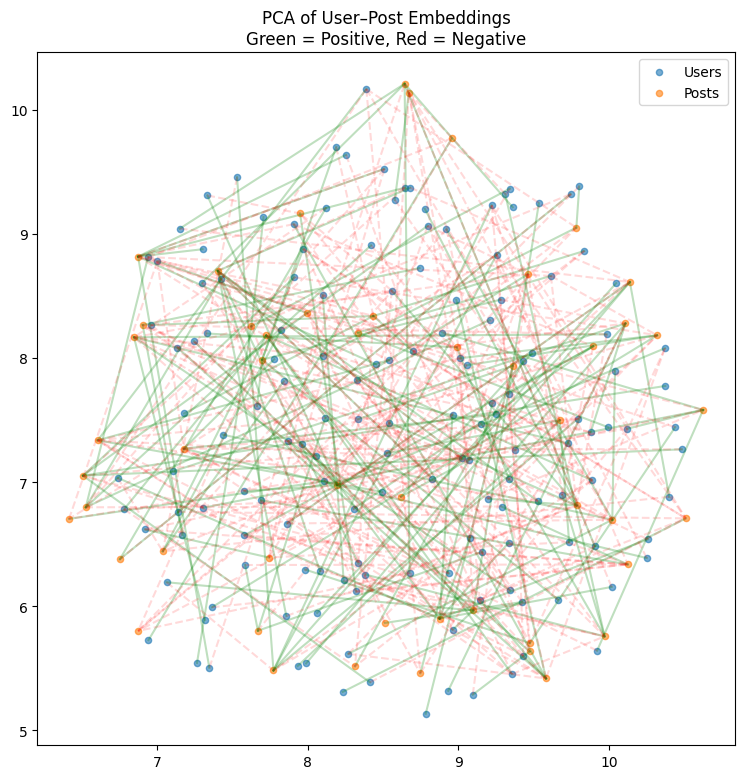

In [47]:
plot_user_post_edges(
    user_tower=user_tower,
    item_tower=item_tower,
    pos_users=users,
    pos_posts=posts,
    neg_pairs=negative_user_post_pairs,
    max_edges=200,
    use_pca=False
)


In [48]:
def avg_distance(user_emb, item_emb, pairs):
    return sum(
        torch.norm(user_emb[u] - item_emb[p]).item()
        for u, p in pairs
    ) / len(pairs)

print("Avg positive distance:",
      avg_distance(user_tower.weight, item_tower.weight, list(zip(users, posts))))

print("Avg negative distance:",
      avg_distance(user_tower.weight, item_tower.weight, negative_user_post_pairs))

Avg positive distance: 7.5045390129089355
Avg negative distance: 8.186781514485677
